In [1]:
# Import of the data 
# This can take a while 

import pyspark.sql.types as T
import pyspark.sql.functions as F
from pyspark.sql import Window

DAU_SCHEMA = T.StructType([
    T.StructField('userId', T.StringType()),
    T.StructField('createdAt', T.StringType()),
    T.StructField('element', T.StringType()),
    T.StructField(
        'data', T.StructType([
            T.StructField('score', T.LongType()),
            T.StructField('activity-title', T.StringType()),
            T.StructField('simplefeedback', T.StringType()),
        ]),
    ),
])

PATH = "s3a://alpha-health-pro/red/evermind/events/2020/04/*/*/*"
evermindDF_raw = spark.read.schema(schema=DAU_SCHEMA).json(PATH)
evermindDF_raw.count()

304155

In [2]:
df = evermindDF_raw\
    .withColumn("date", F.date_format(F.to_timestamp(F.col("createdAt")), "yyyy-MM-dd"))\
    .toPandas()

/Users/yc00123/.virtualenvs/py3.6.8-data-access/lib/python3.6/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
df.dropna(subset = ['data'], inplace=True)

In [4]:
df

,userId,createdAt,element,data,date
0,10b3bcd6-0a21-4a49-a32e-68ebd1953bf6,2020-04-08T00:23:05.168949+01:00,slide,"(None, Your night ritual, None)",2020-04-08
1,10b3bcd6-0a21-4a49-a32e-68ebd1953bf6,2020-04-08T00:23:10.502777+01:00,slide,"(None, Your night ritual, None)",2020-04-08
2,10b3bcd6-0a21-4a49-a32e-68ebd1953bf6,2020-04-08T00:23:12.119739+01:00,slide,"(None, Your night ritual, None)",2020-04-08
3,0bc910b4-950f-4bf3-9b94-247f9f409d91,2020-04-07T19:23:06.886760-04:00,None,"(None, None, None)",2020-04-08
4,3867d941-fa19-4763-ac61-98c6870a2fff,2020-04-07T19:23:15.302382-04:00,slide,"(None, Dominating doubt and uncertainty, None)",2020-04-08
...,...,...,...,...,...
227267,fc5b3ea5-6541-4d74-836c-6b262f7567d3,2020-04-14T23:55:52.109376+01:00,None,"(None, None, None)",2020-04-15
227268,788b34ee-1e56-42c1-bdec-c55185a1ff71,2020-04-01T10:11:54.295003+02:00,None,"(None, None, None)",2020-04-01
227269,700cb20d-3c53-48eb-a0ae-6f57ee1fb11f,2020-04-16T16:10:07.838807-04:00,None,"(None, None, None)",2020-04-16
227270,5fd39651-a617-4c03-b26a-bcef8a936b71,2020-04-18T21:02:54.724417-04:00,None,"(None, None, None)",2020-04-19


In [5]:
import pandas as pd
def get_data(x):
    return x[0], x[1]

df[['score', 'activity']] = df['data'].apply(lambda x: pd.Series(get_data(x)))
df['score'] = pd.to_numeric(df['score'])

In [6]:
#Categorise the activities in relax or thoughts
def get_activity_category(x):
    relax = ['Deep belly breathing', "Beginner's progressive muscle relaxation", 
        'Unguided deep belly breathing (5 min)', 'Progressive muscle relaxation', 
        'Unguided deep belly breathing (3 min)', 'Unguided deep belly breathing']
    thoughts = ['Keeping a thought record', 'Spotting your repetitive thinking', 
        'Recognising unhelpful thoughts', 'Recognising unhelpful thoughts', 
        'Escape your repetitive thoughts']
    if x in relax:
        return 1
    elif x in thoughts:
        return 2
    else:
        return float('NaN')

df['cat'] = df['activity'].apply(lambda x: get_activity_category(x))

In [7]:
df2 = df.groupby(['userId','date'])
df2 = df2['score', 'cat', 'element'].agg(list)
df2.head()

/Users/yc00123/.virtualenvs/py3.6.8-data-access/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


score  \
userId date                                                            
       2020-03-20                          [nan, nan, nan, nan, nan]   
       2020-03-22                                    [nan, nan, nan]   
       2020-03-23                                    [nan, nan, nan]   
       2020-03-24  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
       2020-03-25                                         [nan, nan]   

                                                                 cat  \
userId date                                                            
       2020-03-20                          [nan, nan, nan, nan, nan]   
       2020-03-22                                    [nan, nan, nan]   
       2020-03-23                                    [nan, nan, nan]   
       2020-03-24  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
       2020-03-25                                         [nan, nan]   

                                                             element  
userId date                                                           
       2020-03-20                     [None, None, None, None, None]  
       2020-03-22                                 [None, None, None]  
       2020-03-23                                 [None, None, None]  
       2020-03-24  [None, None, None, None, None, None, None, Non...  
       2020-03-25                                      [login, None]

In [8]:
#Mark the days with an assessment and categorise the PSS in low, medium and high
def get_score_days(x):
    for ele in x: 
        if 0 < ele <= 12:
            return 0, 1
        elif 12 < ele <= 27:
            return 1, 1
        elif ele > 27:
            return 2, 1

df2[['scores', 'score_day']] = df2['score'].apply(lambda x: pd.Series(get_score_days(x)))

/Users/yc00123/.virtualenvs/py3.6.8-data-access/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  # This is added back by InteractiveShellApp.init_path()


In [9]:
def get_raw_score(x):
    for ele in x: 
        if ele > 0:
            return ele

df2['raw_scores'] = df2['score'].apply(lambda x: get_raw_score(x))

In [10]:
df2.dropna(subset = ['score_day'], inplace=True)

In [11]:
import numpy as np
def get_mean_cat(x):
    return np.nanmean(x)
    
    
df2['mean_activity'] = df2['cat'].apply(lambda x: get_mean_cat(x))

/Users/yc00123/.virtualenvs/py3.6.8-data-access/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
df2.dropna(subset = ['mean_activity'], inplace=True)

In [13]:
def get_ratings(x):
    ratings = []
    for ele in x: 
        if ele == 'good':
            ratings.append(2)
        elif ele == 'bad':
            ratings.append(1)
        else: 
            ratings.append(float('NaN'))
    return ratings

df2['ratings'] = df2['element'].apply(lambda x: get_ratings(x))

In [14]:
import numpy as np
def get_mean_rating(x):
    return np.nanmean(x)
    
    
df2['mean_rating'] = df2['ratings'].apply(lambda x: get_mean_rating(x))

/Users/yc00123/.virtualenvs/py3.6.8-data-access/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
df3 = df2.copy()
df3.dropna(subset = ['mean_rating'], inplace=True)

In [16]:
df3

,,score,cat,element,scores,score_day,raw_scores,mean_activity,ratings,mean_rating
userId,date,,,,,,,,,
019c62b4-0135-4ae5-a46c-3f898729cd99,2020-04-07,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[keep_reading, None, new, back, None, new, sta...",1.0,1.0,20.0,2.000000,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",1.000000
02d7f1da-47dd-4c58-b868-feecb3dfee0b,2020-04-21,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[None, None, activity_shape, None, None, None,...",0.0,1.0,8.0,1.000000,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",2.000000
030888cc-e402-428a-b789-85df736a1109,2020-04-02,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, 2.0, nan, 2.0, 2.0, 2.0, 2.0, ...","[None, None, step, activity_shape, None, None,...",0.0,1.0,9.0,2.000000,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",1.666667
036e2ac8-8d5c-4df9-925f-6d4a63145759,2020-04-08,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[None, start_assessment, None, None, None, Non...",1.0,1.0,18.0,2.000000,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",1.000000
059a494f-ff2c-474f-a6bf-6f686bc2e307,2020-04-09,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[None, None, None, None, programme_card, None,...",1.0,1.0,21.0,2.000000,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",2.000000
...,...,...,...,...,...,...,...,...,...,...
f9fb2d35-7171-42f2-99b1-ab61b8bf8bea,2020-04-07,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, nan, nan, ...","[input-done, next, write-feedback, input-done,...",1.0,1.0,20.0,2.000000,"[nan, nan, nan, nan, nan, nan, 2, nan, nan, na...",2.000000
faa191a6-eebd-468d-b17e-fce5c8777228,2020-04-21,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, 2.0, nan, nan, nan, nan, ...","[back, None, list_activity, list_activity, lis...",1.0,1.0,21.0,1.870968,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",2.000000
fb7e54f8-372e-407e-ac8e-3fb85139f84a,2020-04-08,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[None, None, None, None, None, None, None, Non...",2.0,1.0,34.0,2.000000,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",2.000000


## Hypothesis testing

H1: Positive thought journaling will be better at reducing stress than mindfulness in negative (stress) condition

H2: Mindfulness will be equally as effective as positive thought journaling in relaxed condition since the focus on the current thoughts should naturally be positive after relaxed mood induction making both interventions more similar


In [17]:
from scipy import stats
low = df2[df2['scores']==0]['mean_activity']
high = df2[df2['scores']==2]['mean_activity']
stats.ttest_ind(low, high)

Ttest_indResult(statistic=-1.8314324120840593, pvalue=0.06987123764791901)

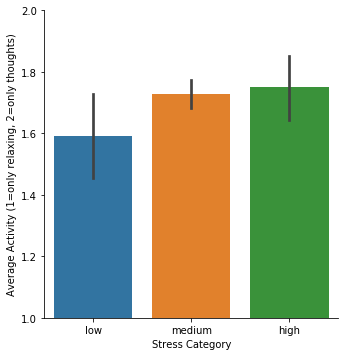

In [18]:
import seaborn as sns
fig = sns.catplot(x="scores", y="mean_activity", kind="bar", data =df2)
fig.set_axis_labels('Stress Category', 'Average Activity (1=only relaxing, 2=only thoughts)')
fig.set_xticklabels(["low", "medium", "high"])
fig.set(ylim=(1,2))

- Found a significant difference between the chosen activities of low and high stress groups (p < .001)
- Users with low stress score prefere relaxing activities, whereas users with high stress scores prefer working with thoughts

In [19]:
from scipy import stats
low = df3[df3['scores']==0]['mean_rating']
high = df3[df3['scores']==2]['mean_rating']
stats.ttest_ind(low, high)

Ttest_indResult(statistic=2.717692173606818, pvalue=0.008229531865736793)

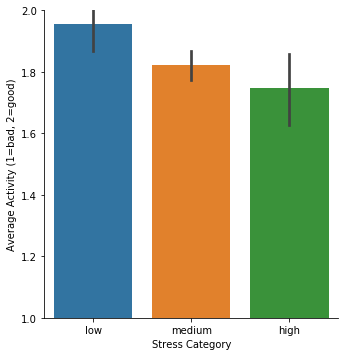

In [20]:
fig = sns.catplot(x="scores", y="mean_rating", kind="bar", data =df3)
fig.set_axis_labels('Stress Category', 'Average Activity (1=bad, 2=good)')
fig.set_xticklabels(["low", "medium", "high"])
fig.set(ylim=(1,2))